<a href="https://colab.research.google.com/github/maudl3116/higherOrderKME/blob/main/examples/N_Bodies_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferring causal graph for interacting bodies
Example in Sec. 4.3 in [paper](https://arxiv.org/pdf/2109.03582.pdf)
***

First we install the higherOrderKME package

In [ ]:
!pip install git+https://github.com/maudl3116/higherOrderKME.git

Here we also need to clone the repository to access the data simulator for this experiment

In [ ]:
!git clone https://github.com/maudl3116/higherOrderKME.git

In [1]:
%cd higherOrderKME

/content/higherOrderKME


Finally we install specific Python libraries for this experiment

In [ ]:
!pip install -r examples/requirements.txt

Optionally run the following cell to get latex figures

In [ ]:
# !sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
# !pip install latex
# !sudo apt install cm-super

Now we generate some data

In [2]:
%cd data/n_vcn_utils/

/content/higherOrderKME/data/n_vcn_utils


In [3]:
from utils import load_data

- run the script exp1.sh to vary the number of samples
- run the script exp2.sh to vary the number of balls

In [ ]:
!sh exp1.sh

In [4]:
%cd ../../

/content/higherOrderKME


**Imports**

In [5]:
import pickle 
import numpy as np
import higherOrderKME
import matplotlib.pyplot as plt
from higherOrderKME.SigKPC.pcskeleton import skeleton

**Define utilities** 

In [6]:
def get_gt_graph(path): 
    graph = pickle.load(open(path,'rb'))
    return graph[0][0][:,0].astype(np.int)


def pred_graph(pval,alpha=0.6,nball=5):
    edge = np.zeros(nball*(nball-1)//2)
    cnt = 0
    for i in range(nball):
        for j in range(i):
            if pval[i,j]<alpha:
                edge[cnt]=0
            else:
                edge[cnt]=1
            cnt+=1
    return edge.astype(int)

**Run experiment**

In [7]:
nball = 5

In [8]:
ground_truth = []
hsics = []
P = 5 # number of values that the parameter we vary takes (e.g. samples = [20,40,60,80,100])
N_rep = 15
for repeat in range(1,N_rep+1):
    print('step:', repeat)
    for i in range(P):
        name_paths = 'data/n_vcn_utils/data/exp1/{0}_Ball/{1}.obj'.format(repeat,i)
        name_graph = 'data/n_vcn_utils/data/exp1/{0}_Ball/graph_{1}.obj'.format(repeat,i)

        # get the distribution
        distri = pickle.load(open(name_paths,'rb'))  # (n_ball, n_samples, T, D) with D = 4. We keep only the first dimensions which correspond to the 2d coordinates
        
        # get ground truth graph 
        graph_gt = get_gt_graph(name_graph)
        
        # run causal discovery
        res = skeleton(distri[:,:,:,:2]*0.01, alpha=0.6, test= False, p=nball, maxi=1, fixedGaps=None, eps=0.01, dyadic_order=2, static='rbf', sigma=10.)
        ground_truth.append(graph_gt)
        hsics.append(res[2].copy())

step: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15


**Use a fraction of the data to fix the threshold $\alpha$**

In [9]:
N = 50 # number of alphas to test
alphas_cv = np.linspace(0.2,2.5,N)

N_train = 5

alpha_scores = np.zeros((P,N_train,N))

c = 0
# train -> decide best alphas
for repeat in range(N_rep):
    for i in range(P):
        true = ground_truth[c]
        pval = hsics[c]

        if repeat<N_train:
          # decide 
          for j in range(N):
            graph_pred = pred_graph(pval,alpha=alphas_cv[j],nball=nball)
            alpha_scores[i,repeat,j] = np.mean(graph_pred.astype(int)==true)
        
        c+=1

best_alphas = np.zeros(P)
for p in range(P):
  avg_score = alpha_scores[p,:N_train,:].mean(axis=0)
  best_alphas[p] = np.argmax(avg_score)

#test -> check results with chosen alphas
results = np.zeros((P,N_rep-N_train))
c = 0
for repeat in range(N_rep):
    for i in range(P):
        true = ground_truth[c]
        pval = hsics[c]

        if repeat >= N_train: 
          graph_pred = pred_graph(pval,alpha=alphas_cv[best_alphas[i].astype(int)],nball=nball)
          results[i,repeat-N_train]  = np.mean(graph_pred.astype(int)==true)
        c+=1

In [10]:
plt.style.use('seaborn')
width = 345

tex_fonts = {
    "text.usetex": True, # set to False if tex not installed
    "font.family": "serif",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}

plt.rcParams.update(tex_fonts)

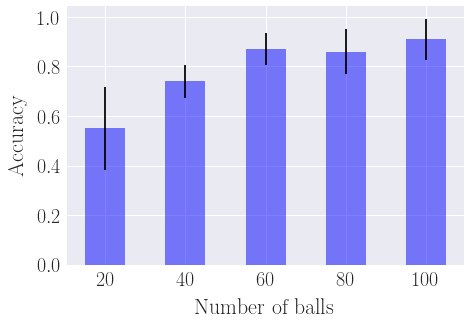

In [13]:
fig, ax = plt.subplots()
ax.bar(np.arange(20,120,20),np.mean(results,axis=1) , yerr=np.std(results,axis=1), align='center', alpha=0.5, ecolor='black', capsize=10,width=10,color='blue')
ax.set_ylabel('Accuracy',labelpad=10)
ax.set_xlabel('Number of balls',labelpad=10)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('exp1.pdf')
plt.show()

In [12]:
print(np.mean(results,axis=1),np.std(results,axis=1))

[0.55 0.74 0.87 0.86 0.91] [0.16881943 0.0663325  0.06403124 0.09165151 0.08306624]
